In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
#data_url = 'http://www.ndbc.noaa.gov/data/5day2/46022_5day.txt'
data_url = 'http://www.ndbc.noaa.gov/data/realtime2/46022.txt'
LAST_HOURS = 24
bouy22_df = pd.read_csv(data_url, header=0, skiprows=[1], nrows=LAST_HOURS, sep='\s+', na_values=['MM', -99])
bouy22_df.head()

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,PTDY,TIDE
0,2016,10,19,21,50,50.0,1.0,2.0,2.0,14,8.9,293,1024.2,13.7,14.0,11.4,NaN,-1.0,NaN
1,2016,10,19,20,50,350.0,1.0,2.0,2.2,14,8.8,294,1024.9,13.5,13.6,10.9,NaN,-0.6,NaN
2,2016,10,19,19,50,330.0,1.0,2.0,2.4,13,9.3,303,1025.4,13.2,13.1,10.1,NaN,0.3,NaN
3,2016,10,19,18,50,30.0,1.0,2.0,2.4,14,9.2,306,1025.2,12.5,12.9,9.3,NaN,0.3,NaN
4,2016,10,19,17,50,50.0,1.0,2.0,2.4,13,8.9,283,1025.5,12.0,13.0,9.4,NaN,0.8,NaN


In [4]:
MWD_df = bouy22_df[['#YY', 'MM', 'DD', 'hh', 'mm', 'WVHT', 'DPD', 'MWD']]
MWD_df.columns = ['year', 'month', 'day', 'hour', 'minute', 'WVHT', 'DPD', 'MWD']
MWD_df.head()

,year,month,day,hour,minute,WVHT,DPD,MWD
0,2016,10,19,21,50,2.0,14,293
1,2016,10,19,20,50,2.2,14,294
2,2016,10,19,19,50,2.4,13,303
3,2016,10,19,18,50,2.4,14,306
4,2016,10,19,17,50,2.4,13,283


In [5]:
ts = pd.to_datetime(MWD_df[['year', 'month', 'day', 'hour', 'minute']], utc=True)
last_hour = ts[0] - pd.DateOffset(hours=7)
first_hour = last_hour - pd.DateOffset(hours=LAST_HOURS)
tlt_str = 'Observations from ' + str(last_hour) + ' to ' + str(first_hour)
[ts.head(), tlt_str]

[0   2016-10-19 21:50:00
 1   2016-10-19 20:50:00
 2   2016-10-19 19:50:00
 3   2016-10-19 18:50:00
 4   2016-10-19 17:50:00
 dtype: datetime64[ns],
 'Observations from 2016-10-19 14:50:00 to 2016-10-18 14:50:00']

In [6]:
# Get pertinate information from bouy22_df and convert meters to feet.
# Change time order to oldest on top.
MWD_df = bouy22_df[['DPD', 'MWD']]
MWD_df.index = ts
feet = np.around(bouy22_df.loc[:,'WVHT'] * 3.4, decimals=1).values
MWD_df.insert(0, 'WVHT', feet)

MWD_df = MWD_df.sort_index(ascending=True, axis=0)
MWD_df

,WVHT,DPD,MWD
2016-10-18 22:50:00,11.6,13,290
2016-10-18 23:50:00,10.5,12,294
2016-10-19 00:50:00,11.9,12,300
2016-10-19 01:50:00,9.2,11,305
2016-10-19 02:50:00,7.8,13,278
2016-10-19 03:50:00,8.2,12,271
2016-10-19 04:50:00,7.1,12,266
2016-10-19 05:50:00,7.1,13,268
2016-10-19 06:50:00,6.5,14,271
2016-10-19 07:50:00,8.2,13,274


In [7]:
MWD_df.describe()

,WVHT,DPD,MWD
count,24.000000,24.000000,24.000000
mean,8.670833,12.666667,285.666667
std,1.432383,0.916831,11.578341
min,6.500000,11.000000,266.000000
25%,8.100000,12.000000,277.750000
50%,8.200000,13.000000,285.000000
75%,9.275000,13.000000,293.250000
max,11.900000,14.000000,306.000000


In [9]:
# Get data for plotting
# Times are changed to ints starting at 2. Degrees are converted to radians.
start_int = 2
r = np.arange(start_int, len(MWD_df) + start_int)
print r
r = np.flipud(r)
print r
theta = np.deg2rad(MWD_df[['MWD']])
period = MWD_df[['DPD']]

# Get info for title string
# Max and min hights will be reported in feet
height_min = MWD_df[['WVHT']].min().values
height_max = MWD_df[['WVHT']].max().values
hts_str =  str(height_min) + '\' to ' + str(height_max) + '\''

# Get most current time reported and convert it from 'UTC' to 'PDT'
date_str = str(MWD_df.index[0] - pd.DateOffset(hours=7))

tlt_str = 'Bouy 22 Last 24 Hours ' + '\n' + date_str + '\n Hts ' + hts_str

# Scale point sizes based on max and min wave height
SMALL_PNT_SZ = 20
LARGE_PNT_SZ = 200
diff = LARGE_PNT_SZ - SMALL_PNT_SZ
m = np.divide(diff, height_max - height_min)
b = (SMALL_PNT_SZ * height_max - LARGE_PNT_SZ * height_min) / (height_max - height_min)

pnt_sz = m*MWD_df[['WVHT']] + b

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
[25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2]


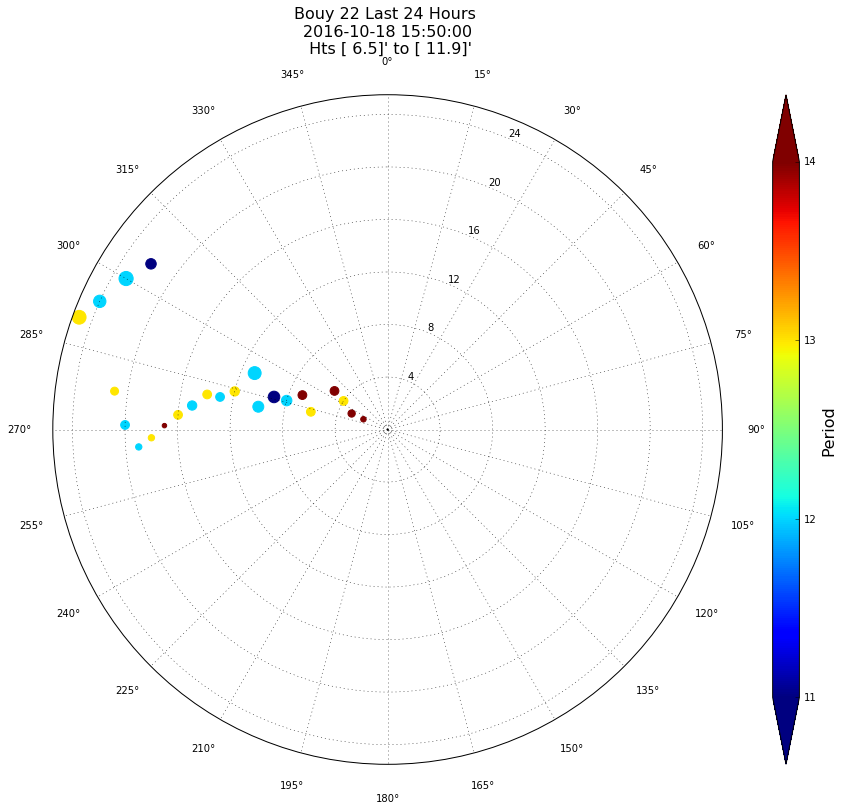

In [10]:
plt.rcParams['figure.figsize'] =[18, 12]

ax = plt.subplot(111, projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)
theta_tics = np.arange(0, 360, 15)
ax.set_thetagrids(theta_tics)
ax.set_rlim([0, 25.5])
r_tics = np.arange(4, 28, 4)
ax.set_rgrids(r_tics)
ax.grid(True)

p = ax.scatter(theta, r, s=pnt_sz, c=period, edgecolors='face')#color='r', linewidth=3)
cbar = plt.colorbar(p, extend='both', extendfrac=0.125)
cbar.set_label('Period', fontsize=16)
cbar.set_ticks(np.arange(period.min(), period.max() + 1))

ax.set_title(tlt_str, va='bottom', fontsize=16)

plt.show(ax)